# Import libraries

In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score,recall_score,f1_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt

## Import the dataset

In [3]:
df = pd.read_csv('../data/name_embeds_incl_special_items_no_context.csv',index_col=0)

In [4]:
df.head()

,name,price,category,embeddings
0,Alete Abendbrei Bio Keksbrei 190g,1.29,Babybedarf,"[-0.047637939453125, 0.006134033203125, 0.0454..."
1,Alete Abendmahlzeit zum Trinken Mehrkorn-Getre...,1.99,Babybedarf,"[-0.033355712890625, 0.0202789306640625, 0.022..."
2,Alete Bio Apfel-Pfirsich mit Keks nach 4. Mona...,1.29,Babybedarf,"[-0.05810546875, 0.0166778564453125, 0.0557556..."
3,Alete Bio Banane-Apfel mit Vollkorn-Getreide 190g,1.29,Babybedarf,"[-0.0217742919921875, 0.0098724365234375, 0.04..."
4,Alete Bio Erbseneintopf 250g,1.59,Babybedarf,"[-0.03509521484375, 0.01074981689453125, 0.061..."


In [5]:
df.tail()

,name,price,category,embeddings
4,"Pfand 0,15 Euro",-0.15,Leergut/Pfand,"[-0.01541900634765625, -0.0072479248046875, 0...."
5,"Pfand 0,25 Euro",-0.25,Leergut/Pfand,"[-0.01593017578125, -0.004364013671875, 0.0382..."
6,"Pfand 0,48 Euro",-0.48,Leergut/Pfand,"[-0.0079193115234375, -0.006732940673828125, 0..."
7,"Pfand 3,10 Euro",-1.50,Leergut/Pfand,"[-0.005565643310546875, -0.002349853515625, 0...."
8,Rabatt 30% Ermäßigung,0.70,Rabatt/Ermäßigung,"[-0.014007568359375, 0.01190948486328125, 0.06..."


In [6]:
df.category.value_counts()

category
Getränke & Genussmittel         2626
Süßes & Salziges                2041
Fertiggerichte & Konserven      2035
Drogerie & Kosmetik             1759
Käse, Eier & Molkerei           1508
Öle, Soßen & Gewürze            1422
Brot, Cerealien & Aufstriche    1352
Kochen & Backen                 1073
Küche & Haushalt                1058
Fleisch & Fisch                  929
Tiefkühlkost                     903
Tierbedarf                       718
Kaffee, Tee & Kakao              663
Babybedarf                       405
Haus & Freizeit                  352
Obst & Gemüse                    277
Leergut/Pfand                      8
Rabatt/Ermäßigung                  1
Name: count, dtype: int64

We need to balance the dataset at least a bit

In [35]:
# Leergut/Pfand category
leergut = df.iloc[-9:-1].values
print(leergut.shape)
leergut_upsample = np.repeat(leergut, 15, axis=0)
print(leergut_upsample.shape)

(8, 4)
(120, 4)


In [42]:
# Rabatt/Ermäßigung category
rabatt_upsample = np.repeat([df.iloc[-1].values], 100, axis=0)
print(rabatt_upsample.shape)

(100, 4)


In [56]:
df_leergut_upsample = pd.DataFrame(leergut_upsample, columns=df.columns)
df_rabatt_upsample = pd.DataFrame(rabatt_upsample, columns=df.columns)
df_upsample = pd.concat([df, df_leergut_upsample, df_rabatt_upsample], ignore_index=True)

In [58]:
print('df:', df.shape)
print('df_leergut_upsample:', df_leergut_upsample.shape)
print('df_rabatt_upsample:', df_rabatt_upsample.shape)
print('df_upsample:', df_upsample.shape)

df: (19130, 4)
df_leergut_upsample: (120, 4)
df_rabatt_upsample: (100, 4)
df_upsample: (19350, 4)


In [59]:
df_upsample.category.value_counts()

category
Getränke & Genussmittel         2626
Süßes & Salziges                2041
Fertiggerichte & Konserven      2035
Drogerie & Kosmetik             1759
Käse, Eier & Molkerei           1508
Öle, Soßen & Gewürze            1422
Brot, Cerealien & Aufstriche    1352
Kochen & Backen                 1073
Küche & Haushalt                1058
Fleisch & Fisch                  929
Tiefkühlkost                     903
Tierbedarf                       718
Kaffee, Tee & Kakao              663
Babybedarf                       405
Haus & Freizeit                  352
Obst & Gemüse                    277
Leergut/Pfand                    128
Rabatt/Ermäßigung                101
Name: count, dtype: int64

The embeddings are stored as lists for each product. In order to use them as features these lists have to be divided, such that each comma-separated value yields a new column --> since the output of mixtral produces 1024 embedings we will receive 1024 columns for the features. Instead of blowing up the dataframe we store the features directly as vectors in a numpy array:

In [65]:
# Using upsampled data for categories Leergut/Pfand and Rabatt/Ermäßigung
df = df_upsample

In [66]:
# convert embeddings column to numpy array of dimension 1000 x 1024 - every product name embedding has 1024 features
import ast 
embeddings = df.embeddings.tolist()
embeddings_list = [ast.literal_eval(s) for s in embeddings]
X = np.array(embeddings_list) 
y = df.category

In [67]:
# create train and test set for the training of the basline model
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)

As a Basline model we train a logisitic regression model with the embeddings (without context) as features and the product categories as targets.

In [68]:
clf = LogisticRegression(max_iter=1000).fit(X_train,y_train)
pred = clf.predict(X_test)

In [26]:
# export LogisitcRegression model
import pickle

with open("LogReg_model.pkl","wb") as f: # save the model in .pkl file
    pickle.dump(clf,f)

In [69]:
print(classification_report(y_test,pred))

                              precision    recall  f1-score   support

                  Babybedarf       0.95      0.79      0.86       101
Brot, Cerealien & Aufstriche       0.74      0.74      0.74       324
         Drogerie & Kosmetik       0.91      0.93      0.92       433
  Fertiggerichte & Konserven       0.75      0.83      0.79       511
             Fleisch & Fisch       0.84      0.82      0.83       225
     Getränke & Genussmittel       0.94      0.98      0.96       682
             Haus & Freizeit       0.93      0.64      0.76        87
         Kaffee, Tee & Kakao       0.96      0.87      0.91       157
             Kochen & Backen       0.76      0.71      0.73       248
       Käse, Eier & Molkerei       0.86      0.82      0.84       396
            Küche & Haushalt       0.85      0.88      0.86       277
               Leergut/Pfand       1.00      1.00      1.00        40
               Obst & Gemüse       0.92      0.42      0.58        78
           Rabatt/E

The basline model already seems to perform quite well, although we have not improved the embeddings (see embedings_api.ipynb) - the embeddings already show a clustering of the products, however the clusters are rather poorly separated.
To check if the model is overfitting we also have a look at the classification report for the train data:

In [70]:
print(classification_report(y_train,clf.predict(X_train)))

                              precision    recall  f1-score   support

                  Babybedarf       0.97      0.77      0.86       304
Brot, Cerealien & Aufstriche       0.79      0.78      0.78      1028
         Drogerie & Kosmetik       0.90      0.95      0.93      1326
  Fertiggerichte & Konserven       0.77      0.88      0.82      1524
             Fleisch & Fisch       0.86      0.83      0.84       704
     Getränke & Genussmittel       0.95      0.99      0.97      1944
             Haus & Freizeit       0.90      0.68      0.78       265
         Kaffee, Tee & Kakao       0.97      0.90      0.93       506
             Kochen & Backen       0.82      0.75      0.78       825
       Käse, Eier & Molkerei       0.87      0.86      0.87      1112
            Küche & Haushalt       0.89      0.89      0.89       781
               Leergut/Pfand       1.00      1.00      1.00        88
               Obst & Gemüse       0.98      0.44      0.61       199
           Rabatt/E

The train data performs only slightly better or rather the scores of the test and train data are close to each other which indicates, that the model is not overfitting.

In [71]:
labels = df.category.unique().tolist()

In [72]:
labels

['Babybedarf',
 'Brot, Cerealien & Aufstriche',
 'Drogerie & Kosmetik',
 'Fertiggerichte & Konserven',
 'Fleisch & Fisch',
 'Getränke & Genussmittel',
 'Haus & Freizeit',
 'Kaffee, Tee & Kakao',
 'Kochen & Backen',
 'Käse, Eier & Molkerei',
 'Küche & Haushalt',
 'Obst & Gemüse',
 'Süßes & Salziges',
 'Tiefkühlkost',
 'Tierbedarf',
 'Öle, Soßen & Gewürze',
 'Leergut/Pfand',
 'Rabatt/Ermäßigung']

Text(49.76909722222221, 0.5, 'True')

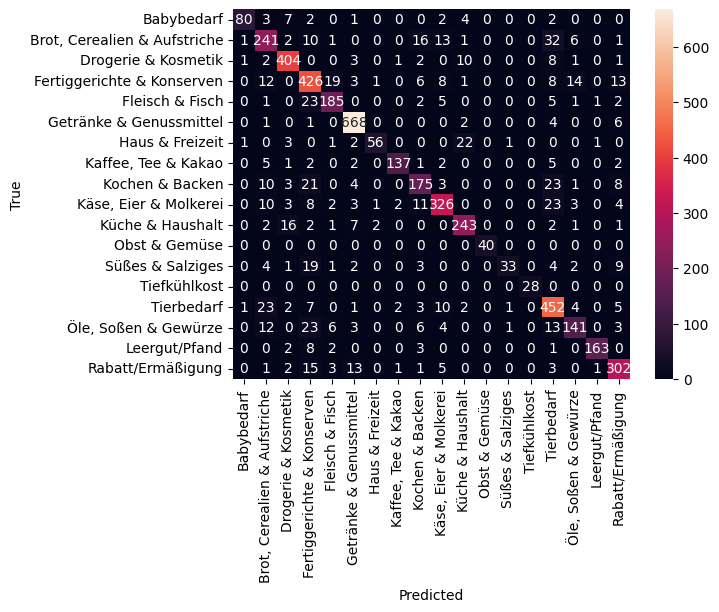

In [73]:
# Print confusion matrix
sns.heatmap(confusion_matrix(y_test,pred),annot=True,fmt='d',xticklabels=labels,yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')

For reference we also try different basic models: DecisionTree and RandomForest

In [74]:
clf_tree = DecisionTreeClassifier(max_depth=12).fit(X_train,y_train)
pred_tree = clf_tree.predict(X_test)

In [75]:
print(classification_report(y_train,clf_tree.predict(X_train)))

                              precision    recall  f1-score   support

                  Babybedarf       0.65      0.23      0.34       304
Brot, Cerealien & Aufstriche       0.52      0.57      0.54      1028
         Drogerie & Kosmetik       0.65      0.83      0.73      1326
  Fertiggerichte & Konserven       0.52      0.68      0.59      1524
             Fleisch & Fisch       0.67      0.62      0.65       704
     Getränke & Genussmittel       0.88      0.85      0.86      1944
             Haus & Freizeit       0.92      0.40      0.55       265
         Kaffee, Tee & Kakao       0.92      0.48      0.63       506
             Kochen & Backen       0.59      0.41      0.48       825
       Käse, Eier & Molkerei       0.65      0.68      0.66      1112
            Küche & Haushalt       0.59      0.66      0.62       781
               Leergut/Pfand       1.00      1.00      1.00        88
               Obst & Gemüse       0.67      0.20      0.30       199
           Rabatt/E

In [76]:
print(classification_report(y_test,pred_tree))

                              precision    recall  f1-score   support

                  Babybedarf       0.14      0.07      0.09       101
Brot, Cerealien & Aufstriche       0.19      0.22      0.21       324
         Drogerie & Kosmetik       0.43      0.53      0.47       433
  Fertiggerichte & Konserven       0.32      0.43      0.37       511
             Fleisch & Fisch       0.38      0.36      0.37       225
     Getränke & Genussmittel       0.73      0.66      0.69       682
             Haus & Freizeit       0.20      0.09      0.13        87
         Kaffee, Tee & Kakao       0.43      0.27      0.33       157
             Kochen & Backen       0.28      0.20      0.23       248
       Käse, Eier & Molkerei       0.43      0.41      0.42       396
            Küche & Haushalt       0.32      0.32      0.32       277
               Leergut/Pfand       0.95      1.00      0.98        40
               Obst & Gemüse       0.04      0.01      0.02        78
           Rabatt/E

The decision tree is much less effective in predicting the right categories, than the logistic regression. The performance of the RandomForest is comparable to the DecisionTree and also worse than the LogisticRegression

In [78]:
clf_forest = RandomForestClassifier(min_samples_leaf=5,max_depth=5).fit(X_train,y_train)
pred_forest = clf_forest.predict(X_test)


In [79]:
print(classification_report(y_test,pred_forest))

                              precision    recall  f1-score   support

                  Babybedarf       0.00      0.00      0.00       101
Brot, Cerealien & Aufstriche       1.00      0.00      0.01       324
         Drogerie & Kosmetik       0.57      0.87      0.68       433
  Fertiggerichte & Konserven       0.28      0.83      0.42       511
             Fleisch & Fisch       1.00      0.03      0.06       225
     Getränke & Genussmittel       0.59      0.99      0.74       682
             Haus & Freizeit       0.00      0.00      0.00        87
         Kaffee, Tee & Kakao       0.00      0.00      0.00       157
             Kochen & Backen       0.00      0.00      0.00       248
       Käse, Eier & Molkerei       0.95      0.27      0.41       396
            Küche & Haushalt       1.00      0.02      0.04       277
               Leergut/Pfand       1.00      1.00      1.00        40
               Obst & Gemüse       0.00      0.00      0.00        78
           Rabatt/E

/Users/leonardkamps/py/ds_bootcamp/ds-capstone/creamCheese-LTJ/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leonardkamps/py/ds_bootcamp/ds-capstone/creamCheese-LTJ/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leonardkamps/py/ds_bootcamp/ds-capstone/creamCheese-LTJ/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. U

In [80]:
print(classification_report(y_train,clf_forest.predict(X_train)))

                              precision    recall  f1-score   support

                  Babybedarf       0.00      0.00      0.00       304
Brot, Cerealien & Aufstriche       1.00      0.01      0.02      1028
         Drogerie & Kosmetik       0.58      0.88      0.70      1326
  Fertiggerichte & Konserven       0.28      0.85      0.42      1524
             Fleisch & Fisch       1.00      0.04      0.07       704
     Getränke & Genussmittel       0.60      0.99      0.75      1944
             Haus & Freizeit       0.00      0.00      0.00       265
         Kaffee, Tee & Kakao       0.00      0.00      0.00       506
             Kochen & Backen       0.00      0.00      0.00       825
       Käse, Eier & Molkerei       0.96      0.39      0.55      1112
            Küche & Haushalt       1.00      0.03      0.06       781
               Leergut/Pfand       1.00      1.00      1.00        88
               Obst & Gemüse       0.00      0.00      0.00       199
           Rabatt/E

/Users/leonardkamps/py/ds_bootcamp/ds-capstone/creamCheese-LTJ/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leonardkamps/py/ds_bootcamp/ds-capstone/creamCheese-LTJ/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leonardkamps/py/ds_bootcamp/ds-capstone/creamCheese-LTJ/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. U

Finally, we try out an XGB model:

In [81]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

In [82]:
df['category'] = pd.Categorical(df.category)
df['num_category'] = df.category.cat.codes

In [83]:
y2 = df.num_category

In [84]:
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X,y2,random_state=42)

In [85]:
xgb = XGBClassifier(random_state=42)
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

#grid_obj_xgb = RandomizedSearchCV(xgb,param_distributions=params, n_iter=5, scoring='roc_auc',n_jobs=-1,verbose=1)

# perform simple model training with the default parameters first, before doing a grid search
fit_xgb = xgb.fit(X_train_xgb,y_train_xgb)

# Get the estimator
#best_clf_xgb = grid_fit_xgb.best_estimator_

pred_xgb = fit_xgb.predict(X_test_xgb)

In [86]:
# export XGBoost model
import pickle

with open("xbg_model_special_items.pkl","wb") as f: # save the model in .pkl file
    pickle.dump(fit_xgb,f)

Text(49.76909722222221, 0.5, 'True')

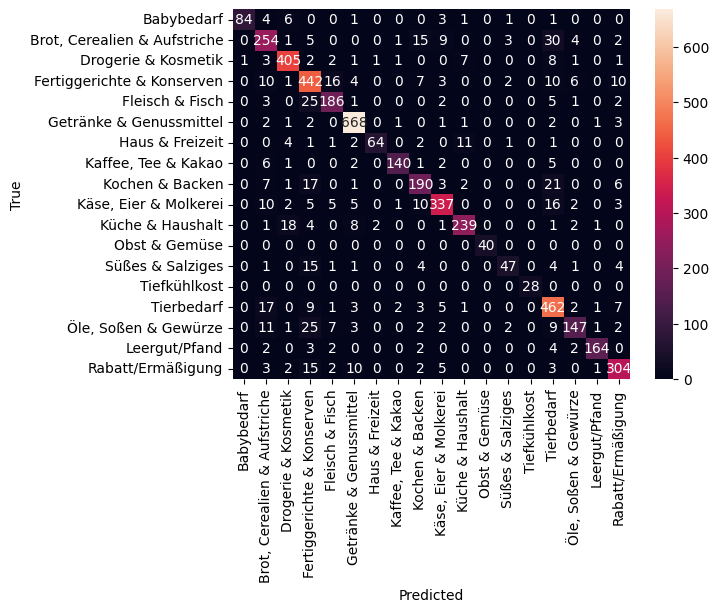

In [87]:
sns.heatmap(confusion_matrix(y_test_xgb,pred_xgb),annot=True,fmt='d',xticklabels=labels,yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')

In [88]:
print(classification_report(y_test_xgb,pred_xgb))

              precision    recall  f1-score   support

           0       0.99      0.83      0.90       101
           1       0.76      0.78      0.77       324
           2       0.91      0.94      0.92       433
           3       0.78      0.86      0.82       511
           4       0.83      0.83      0.83       225
           5       0.94      0.98      0.96       682
           6       0.96      0.74      0.83        87
           7       0.96      0.89      0.92       157
           8       0.80      0.77      0.78       248
           9       0.90      0.85      0.88       396
          10       0.91      0.86      0.89       277
          11       1.00      1.00      1.00        40
          12       0.84      0.60      0.70        78
          13       1.00      1.00      1.00        28
          14       0.79      0.90      0.84       513
          15       0.88      0.69      0.77       212
          16       0.97      0.92      0.94       179
          17       0.88    

Without optimization the XGBoost model outperforms the LogisiticRegression, but there is surely even more to get out of it.